In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast

import seaborn as sns

In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [10]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [78]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    theta = np.random.rand(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            grad *= zeta
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.clip(prob_const * pz, a_min=0, a_max=1)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [87]:
hyperparam_results = pd.read_csv("hyperparams_train_loss.csv", delimiter="\t", header=None)
#hyperparam_results.columns = ["algorithm", "loss", "model_loss", "pz_loss", "hyperparams"]
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [88]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [89]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 4.367045612219314, 'lam': 0.0024946387508891776},
 'polyak_absloss': {'eta': 3.399785576271986,
  'kappa': 1.0246536145319658,
  'kappa0': 0.9023342980972957,
  'lam': 0.002485007890991794,
  'omega': 1.0000992392729837},
 'polyak_exponent': {'eta': 2.73686186717682,
  'kappa': 1.8499597753236043,
  'kappa0': 0.8175523204596161,
  'lam': 0.0024901191579937616},
 'random': {'eta': 4.469620242177973, 'lam': 0.0024837341213267946}}

In [74]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 2.4150158663969354, 'lam': 0.002611877401932275},
 'polyak_absloss': {'eta': 2.060509666179811,
  'kappa': 1.9098375529157579,
  'kappa0': 0.7913533076546468,
  'lam': 0.0027401911444250022,
  'omega': 1.0000174757551765},
 'polyak_exponent': {'eta': 1.3170782750675603,
  'kappa': 1.4247674883727435,
  'kappa0': 0.8121138806173126,
  'lam': 0.0025221994304522955},
 'random': {'eta': 3.7969366203556163, 'lam': 0.0025306357176630677}}

In [23]:
# When minimizing model_loss
hyperparam_per_algo

{'absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'polyak_absloss': {'eta': 0.2533878780610889,
  'kappa': 1.095912516545561,
  'kappa0': 0.6667920004353213,
  'lam': 0.10342639824492761,
  'omega': 0.16257709798900413},
 'polyak_exponent': {'eta': 0.27915609787853457,
  'kappa': 1.7481012969747458,
  'kappa0': 0.14181445192072495,
  'lam': 0.5067666439089842,
  'polyakexp': 1.6973586642272622},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [25]:
# When minimising loss
hyperparam_per_algo

{'absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'polyak_absloss': {'eta': 0.302089434185744,
  'kappa': 1.895817909702363,
  'kappa0': 0.11343654484532181,
  'lam': 0.05332573511617056,
  'omega': 0.9996724113893498},
 'polyak_exponent': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [90]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6925539306614641, train loss: 0.3330399711775689, ||theta||_1: 3205.470752693897
loss: 0.6896433631374989, train loss: 0.78323702188278, ||theta||_1: 1994.5879545240482
loss: 0.6881910074280431, train loss: 0.8204228337931007, ||theta||_1: 1308.6166856778414
loss: 0.6877937186460233, train loss: 0.73411559680898, ||theta||_1: 929.8513848009902
loss: 0.687378564168852, train loss: 0.677873884083509, ||theta||_1: 715.0449574070727
loss: 0.686865890051149, train loss: 0.6726082402194293, ||theta||_1: 579.7775128292516
loss: 0.6869515811305758, train loss: 0.6946914239299923, ||theta||_1: 519.0968799362112
loss: 0.6869419091427542, train loss: 0.6697869067674783, ||theta||_1: 490.21087604295684
loss: 0.6867483794035772, train loss: 0.6776549485507788, ||theta||_1: 477.14016088958334
loss: 0.6865989667034609, train loss: 0.6901635836036436, ||theta||_1: 470.2374445910459
loss: 0.6869490339666194, train loss: 0.690262609905

In [91]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [92]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6922077312154709, train loss: 0.416586036034003, ||theta||_1: 3242.2788563562845
loss: 0.6896195212531259, train loss: 0.9188982210785854, ||theta||_1: 1987.0307684495422
loss: 0.6881508849654792, train loss: 0.7093381540440615, ||theta||_1: 1250.0511174856408
loss: 0.6875403586747733, train loss: 0.7250396208443702, ||theta||_1: 886.214171692076
loss: 0.6872307987069279, train loss: 0.7178003214352668, ||theta||_1: 696.1363161455133
loss: 0.6869835764303246, train loss: 0.6737549967034983, ||theta||_1: 597.4943995363041
loss: 0.6867631692688939, train loss: 0.6956018815178437, ||theta||_1: 530.7222971253802
loss: 0.6868575436228219, train loss: 0.6456407329283504, ||theta||_1: 499.5207354847786
loss: 0.6869800499998052, train loss: 0.6823132261084898, ||theta||_1: 483.13934331886475
loss: 0.6867454289116469, train loss: 0.6849832387954143, ||theta||_1: 473.94611357993296
loss: 0.6868556436935213, train loss: 0.6879373

In [ ]:
# 0.05316837000465253 overfits
# 0.10316837000465253 loss goes up continuously
results_rand = train_model(
    X, y, Xtest, ytest, mode="rand", verbose=True, **{'eta': 0.06643063763463221, 'lam': 0.10316837000465253, 'pz0': absloss_mean_sampling_prob}
)

In [71]:
# Intermediate hyperparam from the new train-loss tuning run

train_model(
    X, y, Xtest, ytest, mode="rand", verbose=True, **{'eta': 2.5822524658172803, 'lam': 0.002596189607233007, 'pz0': absloss_mean_sampling_prob}
)

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6922842441220642, train loss: 0.5224469145761488, ||theta||_1: 3278.6396513524314
loss: 0.6904581324628171, train loss: 0.8250748741176299, ||theta||_1: 2332.3350578766754
loss: 0.6892887934458612, train loss: 0.7264388956928386, ||theta||_1: 1728.0283007189278
loss: 0.688542144003427, train loss: 0.7110464980745863, ||theta||_1: 1317.7815835868369
loss: 0.6880054719497759, train loss: 0.7253038194601625, ||theta||_1: 1024.4501222530344
loss: 0.6875238786210572, train loss: 0.678312952965907, ||theta||_1: 826.1656437788401
loss: 0.6874514280797335, train loss: 0.7350038522322848, ||theta||_1: 712.578822884469
loss: 0.6874608655083573, train loss: 0.66280471707603, ||theta||_1: 627.3314344392895
loss: 0.6873475387661394, train loss: 0.6479414540143937, ||theta||_1: 562.6577395736266
loss: 0.6871401066719356, train loss: 0.665131731113884, ||theta||_1: 521.6018159837035
loss: 0.6871677764211174, train loss: 0.6560962981665

{'losses': [0.5224469145761488,
  1.3384582596777044,
  0.8390837789028015,
  1.0236828521039294,
  1.2906190439609566,
  0.9939395572521875,
  0.5735469862222611,
  1.35963598788278,
  0.3200528031279526,
  1.2556340625471896,
  0.5167693318375035,
  0.5824950663368897,
  1.051463967223396,
  1.1828022020835107,
  0.36151020589642635,
  0.739195687573375,
  0.3789713206309945,
  0.8791574830885744,
  1.3218920351141479,
  0.6092500780199299,
  0.9240185779082802,
  0.8190659142327319,
  0.4171752994406375,
  0.9990403600299842,
  0.3138858037151494,
  0.4040952793577505,
  1.138049375427095,
  0.30819540466134787,
  1.0649696111411708,
  0.8013506232245556,
  0.3337770359914803,
  0.7598835251205954,
  0.9032678883208177,
  0.4187836616509022,
  0.36020081969345114,
  0.48574470885520493,
  0.6625813717924076,
  1.1925069599569842,
  0.5104119651214402,
  0.9879739719375474,
  1.0726301384148478,
  0.48997062564046495,
  1.0156711245902945,
  0.9326503675444792,
  0.4961587601029032,


In [70]:
# Lambda values:
# 0.05316837000465253 overfits
# 0.10316837000465253 test loss goes up continuously
# 0.01031683700046525 test loss trends down as we expect. Final test loss 0.69160. Train loss trends down to 0.6624
# 0.00103168370004652 test loss trends down as we expect. Final test loss 0.69075. Train loss trends down to 0.4444
# 0.00000000000000000 test loss trends down as we expect. Final test loss 0.69110. Train loss trends down to 0.5439
results_rand = train_model(
    X, y, Xtest, ytest, mode="rand", verbose=True, **{'eta': 0.06643063763463221, 'lam': 0, 'pz0': absloss_mean_sampling_prob}
)

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6927694791405374, train loss: 0.30896273822235204, ||theta||_1: 3240.388707069429
loss: 0.6927250689747, train loss: 0.9628611347602513, ||theta||_1: 3239.972911001086
loss: 0.6926736724698734, train loss: 0.7849309806067655, ||theta||_1: 3238.794014104755
loss: 0.6926259908770811, train loss: 1.383245397159935, ||theta||_1: 3238.1556508086132
loss: 0.6925740709840771, train loss: 0.8392176694805253, ||theta||_1: 3237.822748348233
loss: 0.6925156995388162, train loss: 0.48763920646234715, ||theta||_1: 3236.5739053769958
loss: 0.692468054224362, train loss: 1.0068835499104807, ||theta||_1: 3235.796994105296
loss: 0.6924134620294549, train loss: 0.32651454201016444, ||theta||_1: 3234.6769001152315
loss: 0.6923626914838819, train loss: 0.540782974367237, ||theta||_1: 3234.1664183411194
loss: 0.6923185069484604, train loss: 0.3697089675648481, ||theta||_1: 3233.544392152152
loss: 0.6922682369671979, train loss: 0.52144159626

In [93]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6927838186741246, train loss: 0.3813462327966563, ||theta||_1: 3269.8515424900684
loss: 0.6899923270390477, train loss: 0.917826394202557, ||theta||_1: 1987.6508154618896
loss: 0.6883809122664419, train loss: 0.8628970967945236, ||theta||_1: 1318.3880014907197
loss: 0.6877631796947569, train loss: 0.7153239243969812, ||theta||_1: 916.5802985504646
loss: 0.6870258389387363, train loss: 0.69041916595576, ||theta||_1: 696.21687374255
loss: 0.686662088562201, train loss: 0.6718675806881086, ||theta||_1: 584.2199455195847
loss: 0.686625056706903, train loss: 0.6973029755427592, ||theta||_1: 527.365156481435
loss: 0.6867666526684088, train loss: 0.6899094212341348, ||theta||_1: 490.9814826585533
loss: 0.6868410128357216, train loss: 0.680556717953857, ||theta||_1: 478.7497405000401
loss: 0.6868425725850966, train loss: 0.6852289469105866, ||theta||_1: 471.2964088247782
loss: 0.6869601868325934, train loss: 0.6618515205419482

In [94]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6921887371628599, train loss: 0.5228237200823046, ||theta||_1: 3240.6250931205213
loss: 0.689535970454939, train loss: 0.7777015364814496, ||theta||_1: 2011.54776123994
loss: 0.6881467066397663, train loss: 0.7728560392807536, ||theta||_1: 1286.4688226099336
loss: 0.687503240347271, train loss: 0.8011573271768113, ||theta||_1: 901.7845299734552
loss: 0.6871514321520782, train loss: 0.7256524897259714, ||theta||_1: 687.6854803442511
loss: 0.6868725534906744, train loss: 0.6714450970714315, ||theta||_1: 559.4918267127023
loss: 0.6867642101517035, train loss: 0.6885343828153296, ||theta||_1: 507.86124781415657
loss: 0.6869220915426032, train loss: 0.6832417683181623, ||theta||_1: 484.07543467129784
loss: 0.6868914069278578, train loss: 0.6841274902184901, ||theta||_1: 475.7858822347947
loss: 0.6866080649464231, train loss: 0.6901920333453135, ||theta||_1: 470.1882965760785
loss: 0.6866240133945665, train loss: 0.65999627

In [95]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        dfs += [df]

    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

<Axes: xlabel='iteration', ylabel='test_accuracy'>

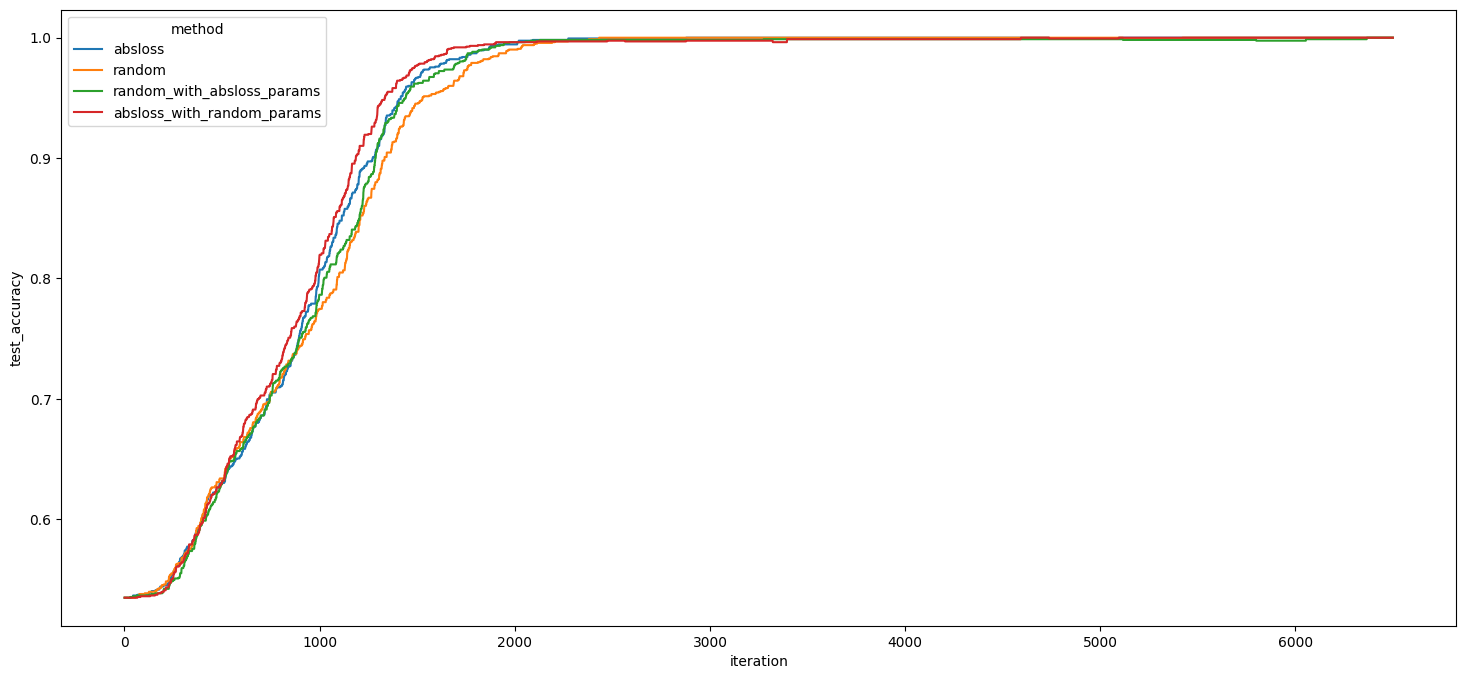

In [96]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_accuracy,
    hue=results_df.method
)

<Axes: xlabel='iteration', ylabel='test_loss'>

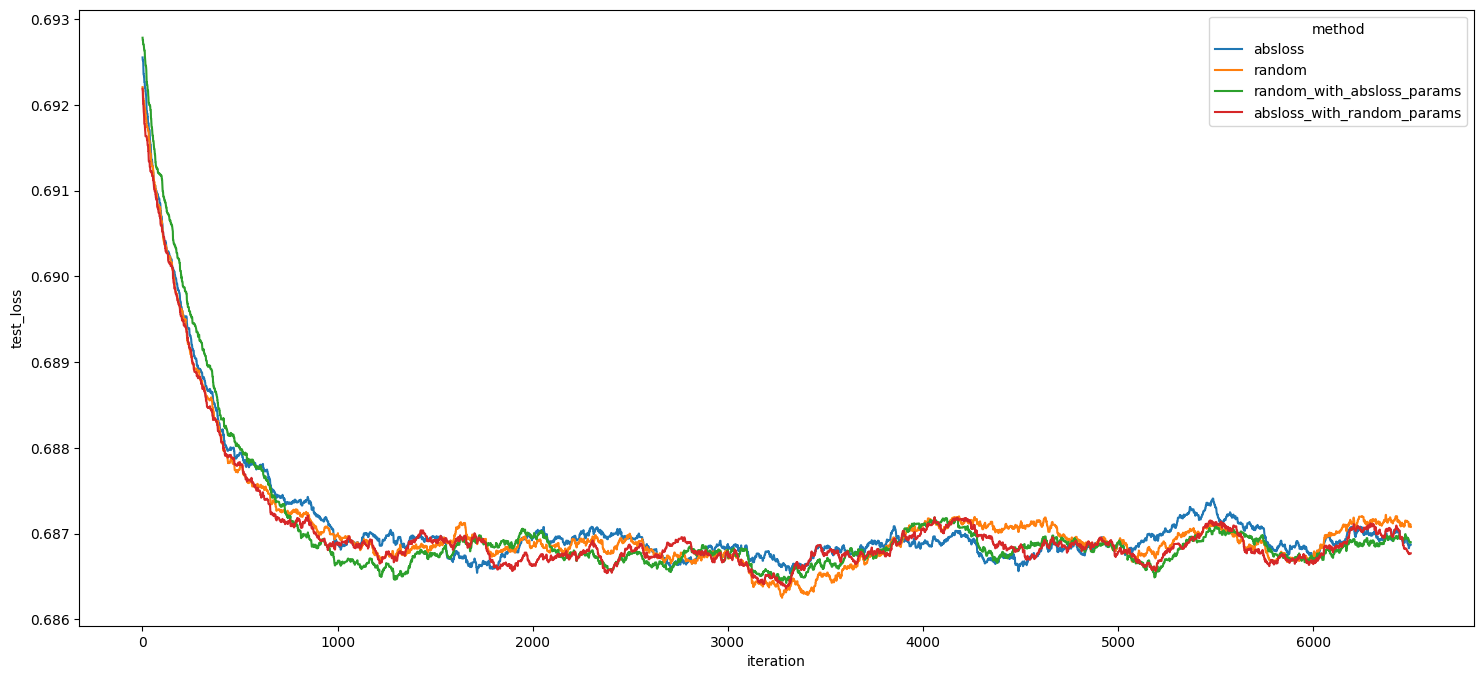

In [97]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_loss,
    hue=results_df.method
)

(0.0, 1500.0)

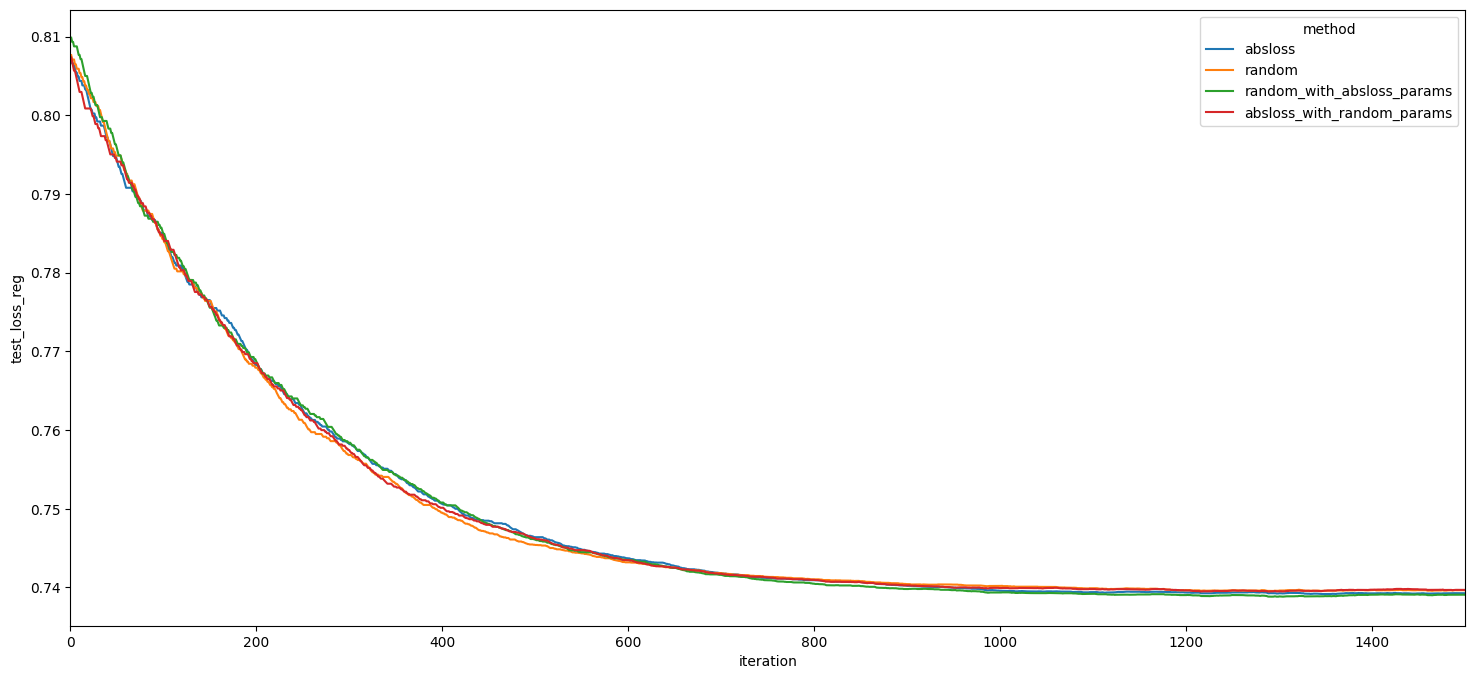

In [98]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_loss_reg,
    hue=results_df.method
)
ax.set_xlim((0, 1500))

<Axes: xlabel='iteration'>

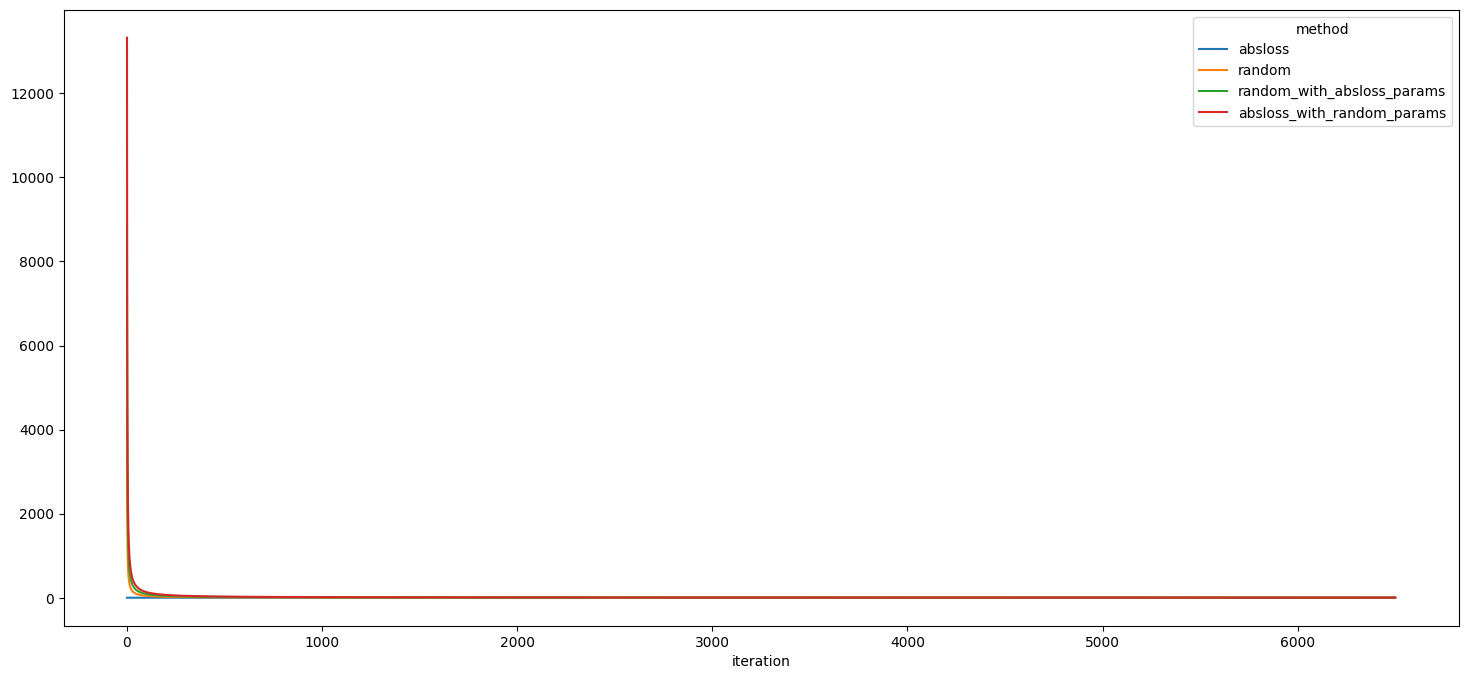

In [109]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=np.cumsum(results_df.train_loss) / results_df.iteration,
    hue=results_df.method
)

In [ ]:
## Old hypertune results below this line

<Axes: xlabel='iteration', ylabel='test_accuracy'>

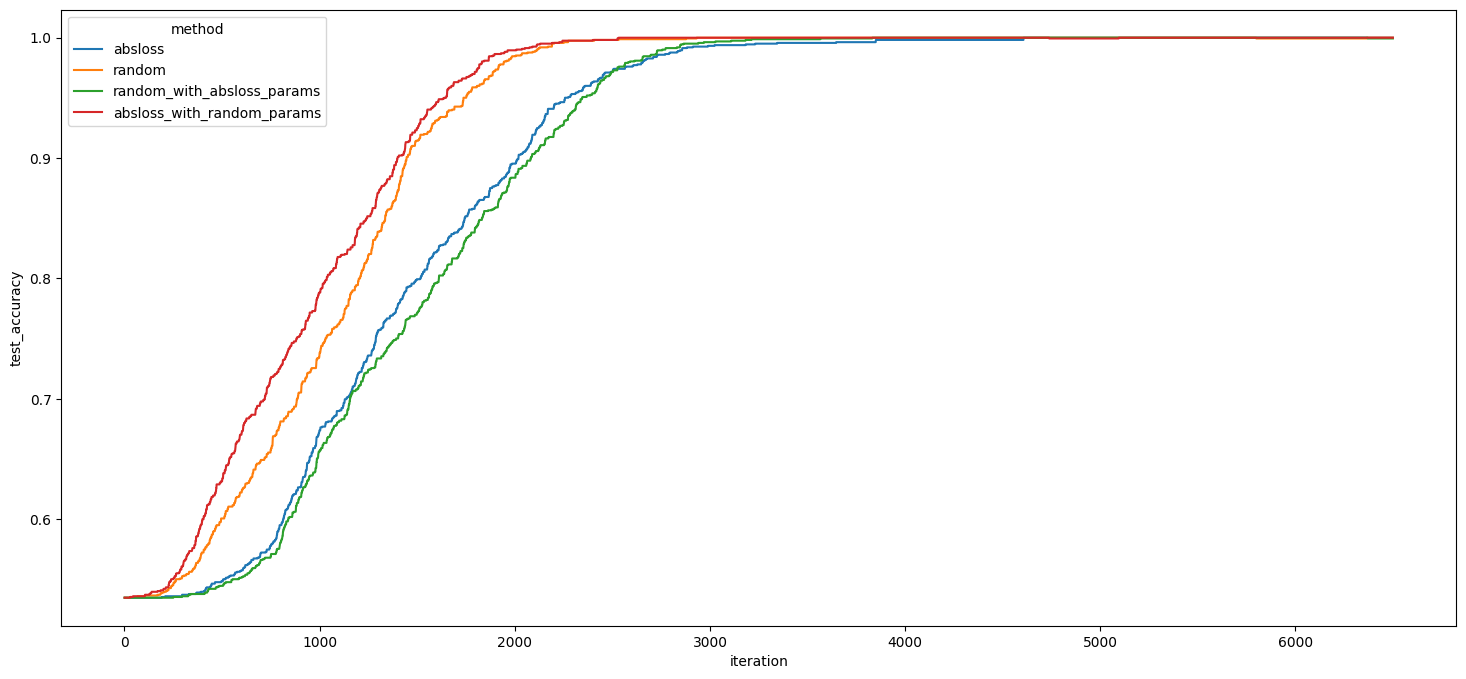

In [83]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_accuracy,
    hue=results_df.method
)

<Axes: xlabel='iteration', ylabel='test_loss'>

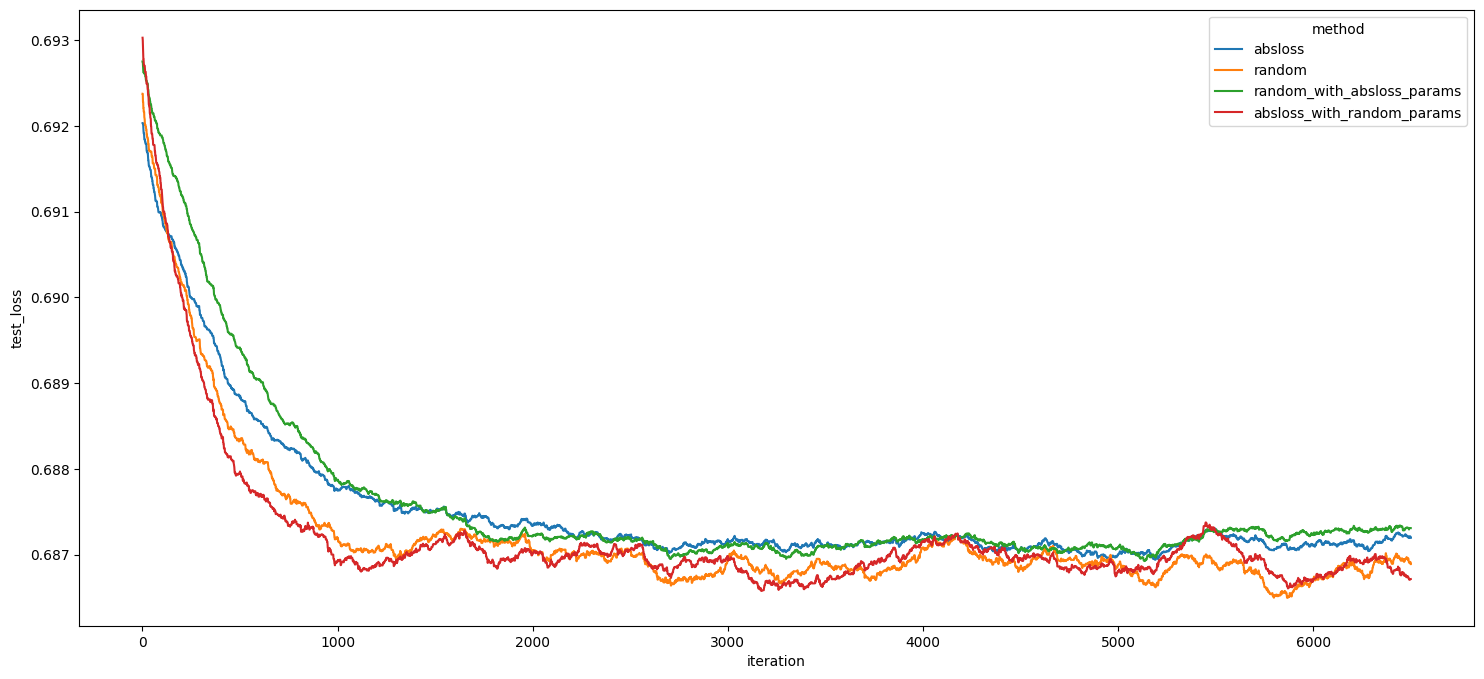

In [84]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_loss,
    hue=results_df.method
)

In [ ]:
## OLD RESULTS BELOW THIS LINE

<Axes: xlabel='iteration', ylabel='test_accuracy'>

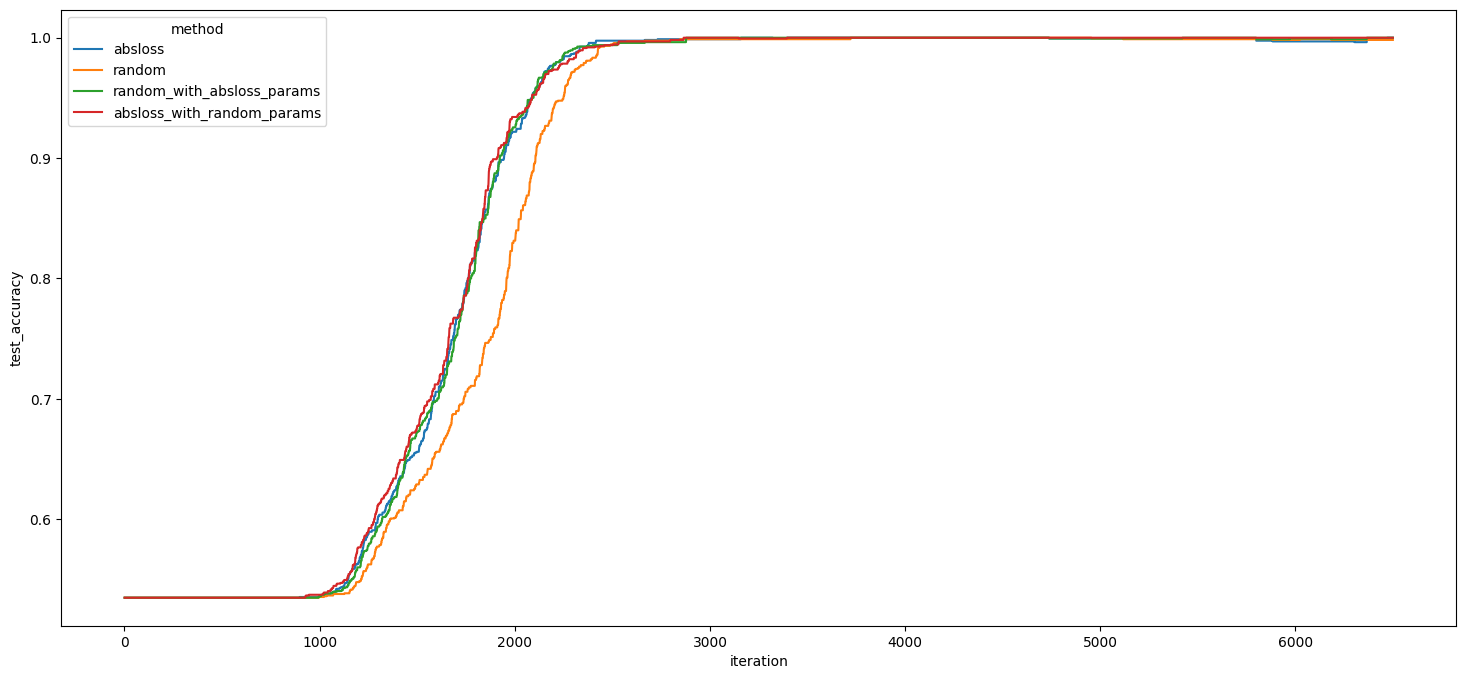

In [55]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_accuracy,
    hue=results_df.method
)

<Axes: xlabel='iteration', ylabel='test_loss'>

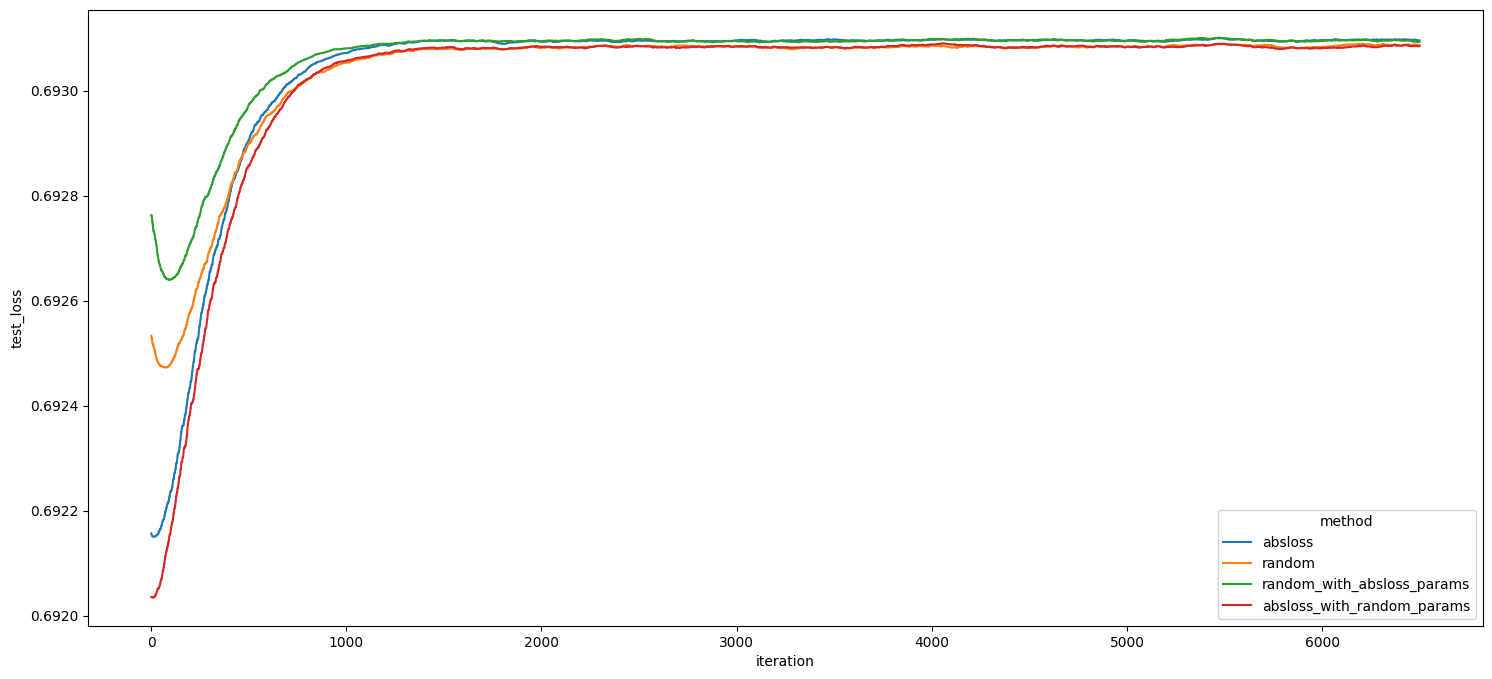

In [56]:
plt.figure(figsize=(18,8))

sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_loss,
    hue=results_df.method
)

(0.0, 1500.0)

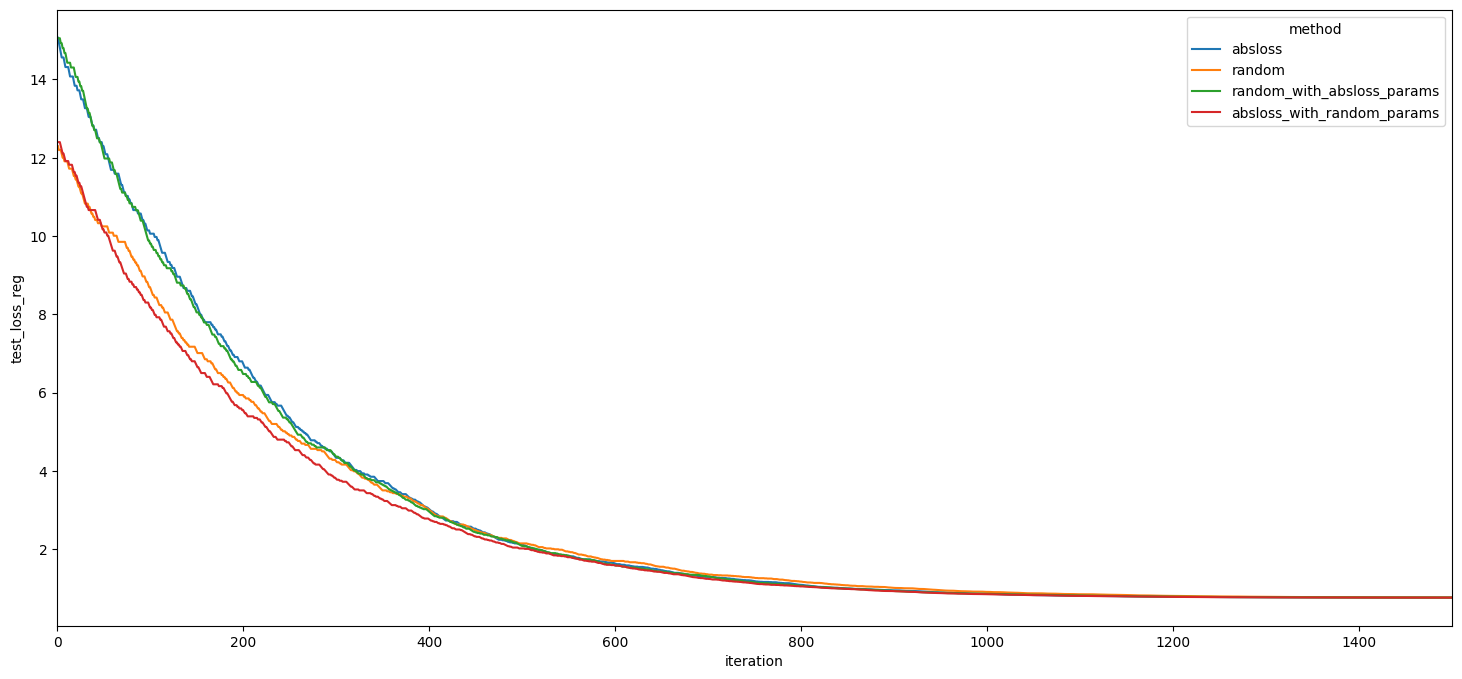

In [60]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    x=results_df.iteration, 
    y=results_df.test_loss_reg,
    hue=results_df.method
)
ax.set_xlim((0, 1500))

(0.0, 1500.0)

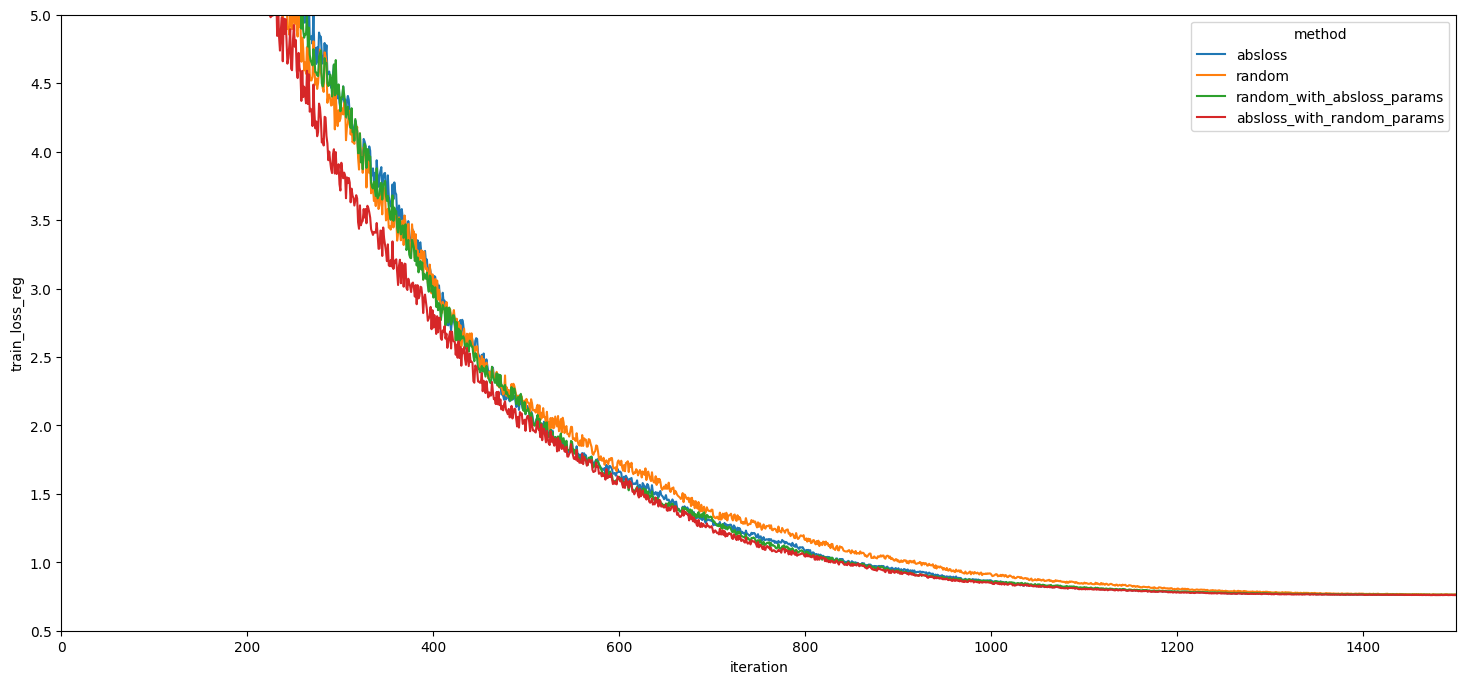

In [63]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    x=results_df.iteration, 
    y=results_df.train_loss_reg,
    hue=results_df.method
)
ax.set_ylim((0.5, 5))
ax.set_xlim((0, 1500))